# An Example: How a learner's performance varies with the data perturbation strategy?

##### T.A Şeymanur Aktı - akti15@itu.edu.tr

In this tutorial we will learn how to train and evaluate classifier and regressor on various datasets using cross-validation. Then we will examine the effect of chosen CV strategy and the random anchor seed on the performance.

#### First, let's see why we need cross validation at all:

<div>
<img src="images/cv_img1.png" width="500"/>
</div>

#### Because we can have different learners for various train / test splits.

<div>
<img src="images/cv_img2.png" width="500"/>
</div>

#### In order to be able to evaluate our models in a more fair way we can use cross-validation. Also, it is possible to use it when we have less amount of data than we need. Instead of seperating another set of data for test set we can use cross-validation for evaluation. Now, let's do some experiments to see the effect of cross-validation on learner.

## Import Cell

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as ds
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

We will examine the cross-validation approach in 3 different experimental setups as:
   - Supervised regression: Regression task where we know the corresponding values for the data points.
   - Supervised classification: Classification task where we know the corresponding class for the data points.
   - Unsupervised classification: Classification task where we only know the distribution of data points and do not know the classes.

## Experiment 1: Supervised regression on Boston House Prices dataset

Regression tackles the problems where the data points with related features are given and we want to learn the output variable which is a continuous value. The main task is estimating the hyperplane that data points lay on.

 - **Training set:** The data samples (houses) with relative features (age, location etc.) where we know the value outcome (price) of them. The parameters of the learner are determined only based on the training data samples.

 - **Test set:** The houses which we want to predict their prices. This set is used for evaluation where the actual prices remain unseen for the model.
 

In [ ]:
def load_boston_dataset():
    
    data = ds.load_boston()
    
    print("Number of samples: ", data.data.shape[0])
    print("Number of attributes: ", data.data.shape[1])
    
    return data
    

First, let's load the dataset and examine the dataset information.

In [ ]:
boston_data = load_boston_dataset()

df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
df.head()

Then, let's train and test the learner on a single split. We can use the **train_test_split** function to split the data into training and test sets. Below, we split the dataset as 80% is the training and 20% is the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boston_data.data, boston_data.target, test_size=0.2, shuffle=True)
print("Train set size: ", X_train.shape)
print("Test set size: ", X_test.shape)

It is time to train the learner on the training set. During supervised training, we use both data points and their value labels for learning the data distribution.

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

We have trained our regressor on training set and estimated a hyperplane for the data points. Now, we need to evaluate the model on the **unseen test set** which we did not use during training. If the model predicts the correct prices for the houses that it sees for the first time, this means it really learns the mapping between house features and their prices. 

In [ ]:
y_pred = regressor.predict(X_test) # evaluation on the unseen test set
y_pred_train = regressor.predict(X_train) # we also want to see the model performance on training set

print("Train MSE: ", mean_squared_error(y_pred_train, y_train))
print("Test MSE: ", mean_squared_error(y_pred, y_test))

Mean squared error is a common metric for evaluation of regression models which measures the mean squared error between predicted house prices and the actual prices. Less is better.

At the next step, we will examine the 5F cross-validation strategy on the same dataset. Instead of training and evaluating the model on a single train-test split, we will use 5 different splits and measure the overall results for a better evaluation. We can use the **KFold** function from the sklearn library to implement cross-validation easily.

In [ ]:
def train_regressor_CV(X, y, fold=5, shuffle=False, seed=None):

    cv_splits = KFold(fold, shuffle=shuffle, random_state=seed) 
    

    regressor = LinearRegression()
    train_mses = []
    test_mses = []

    for n, (train_index, test_index) in enumerate(cv_splits.split(X)):
        
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        regressor.fit(X_train, y_train)
        
        y_preds_train = regressor.predict(X_train)
        y_preds_test = regressor.predict(X_test)
        
        train_mse = mean_squared_error(y_train, y_preds_train)
        test_mse = mean_squared_error(y_test, y_preds_test)
        print("Test accuracy for fold", n, ": ", test_mse)
        
        train_mses.append(train_mse)
        test_mses.append(test_mse) 
    
    print("\n")
    print("Mean accuracy: ", np.mean(test_mses))
    print("Variation of accuracies: ", np.std(test_mses))
    return np.mean(test_mses), np.std(test_mses)

The training function above splits the dataset into K parts and trains K models. For each model, 1 partition is used as test set and the model trained on the remaining K-1 partitions. 

The random anchor seed / random state parameters defines the randomization parameters we use when shuffling and splitting the dataset. Using the same random seed gives us the same splits each time and this make the results reproducable.

In [ ]:
X, y = boston_data.data, boston_data.target
mean, std = train_regressor_CV(X, y, fold=5, shuffle=True, seed=3)

## Experiment 2: Gradient Descent:

Gradient descent is a local optimization method where we start from $w_0$ and take some steps as $w_1, w_2, w_3 ...$ to reach the minimum with respect to gradient.

<div>
<img src="https://jermwatt.github.io/machine_learning_refined/mlrefined_images/math_optimization_images/Fig_2_7.png" width="500"/>
</div>

#### Reaching minimum means finding the optimal $w$ value that gives the lowest loss. In order to do that we are using first derivative of the loss function.

#### Optimization process is as follows:
   - Define an initial $w_0$
   - For each step in gradient descent:
       - Calculate the gradient wrt w: $\nabla g(w) $
       - Update the weight $w_k = w_{k-1} - \alpha \nabla g(w_{k-1}) $

### Now, we will see how to implement gradient descent.

In [ ]:
# import standard tools
import sys
sys.path.append('../')
import autograd.numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# import custom plotting tools
from mlrefined_libraries import math_optimization_library as optlib
static_plotter = optlib.static_plotter.Visualizer();
anime_plotter = optlib.animation_plotter.Visualizer();

# The next three lines are needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# center all images in notebook and associated html
from IPython.display import HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
    width="400";
    height="400";
}
</style>
"""))

In [ ]:
# import automatic differentiator to compute gradient module
from autograd import grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run gradient descent 
w = 2.5; alpha = 1; max_its = 25;
weight_history,cost_history_gd = gradient_descent(g,alpha,max_its,w)

# # animate gradient descent applied to minimizing this function
# anime_plotter.gradient_descent(g,weight_history,savepath='animation_1.mp4',fps=1)

# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="animation_1.mp4" type="video/mp4">
  </video>
""")

### There are two things to be careful about!
   - Initializing the $w_0$
   - Choosing the best step size / learning rate / $\alpha$
   
#### You can see the effect of alpha on converging. Setting a too low step size makes it longer to converge and setting it too high just makes the learner blow up.

![LRURL](https://github.com/jermwatt/machine_learning_refined/blob/gh-pages/html/gifs/steplength_1D.gif?raw=true)

#### Also, the position of $w_0$ affects the minimum that we found. 

<div>
<img src="images/grad_desc_img2.png" width="700"/>
</div>

#### Let's experiment it!

In [ ]:
#what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.1*w**2

# run gradient descent
alpha = 0.05; w = 4.5; max_its = 10;
weight_history_1,cost_history_1 = gradient_descent(g,alpha,max_its,w)

alpha = 0.05; w = -1.5; max_its = 10;
weight_history_2,cost_history_2 = gradient_descent(g,alpha,max_its,w)

# make static plot showcasing each step of this run
# static_plotter.single_input_plot(g,[weight_history_1,weight_history_2],[cost_history_1,cost_history_2],wmin = -5,wmax = 5)

In [ ]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = True,labels = ['run 1','run 2'])

#### Next, experimenting the learning rate / step size effect on optimization.

In [2]:
# what function should we play with?  Defined in the next line., nice setting here is g = cos(2*w), w_init = 0.4, alpha_range = np.linspace(2*10**-4,1,200)
g = lambda w: np.sin(w[0])

# create an instance of the visualizer with this function
demo = optlib.grad_descent_steplength_adjuster_3d.visualizer()

# run the visualizer for our chosen input function, initial point, and step length alpha
w_init = [1,0]; alpha_range = np.linspace(2*10**-4,5,200); max_its = 10; view = [10,120];
demo.animate_it(savepath='animation_2.mp4',g = g,w_init = w_init,alpha_range = alpha_range,max_its = max_its,view = view,fps=10)

NameError: name 'optlib' is not defined

In [1]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="animation_2.mp4" type="video/mp4">
  </video>
""")

### Now, it's your turn! 
You will implement gradient descent on your own. Do not forget to test the learner with different learning rates and $w_0$ values to find the optimum parameter. You can calculate the gradient by hand. Fill the blank in following cell. The function we need to minimize is:

<center>
    $ g(w) = w_0^2 + w_1^2 + 2 sin (w_0 + w_1) + 2 $


In [ ]:
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]   # container for corresponding cost function history
    
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        
        ##### FILL HERE #####
        
        grad_w0 = 2*w[0] + 2*np.cos(w[0] + w[1])
        grad_w1 = 2*w[1] + 2*np.cos(w[0] + w[1])
                                        
        ##### FILL HERE #####

        # take gradient descent step
        w = w - alpha * np.array([grad_w0, grad_w1])
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

In [ ]:
# what function should we play with?  Defined in the next line.
g = lambda w: w[0]**2 + w[1]**2 + 2*(np.sin(w[0] + w[1])) + 2

# run gradient descent 
w = np.array([0, 3]); max_its = 10; alpha = 0.003;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,num_contours = 25,view = [10,30])

## Experiment 3: Gaussian Bayes classifier

In [3]:
%matplotlib inline

from sklearn.datasets import make_blobs, make_moons, make_regression, load_iris
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

(150, 2)
(150,)


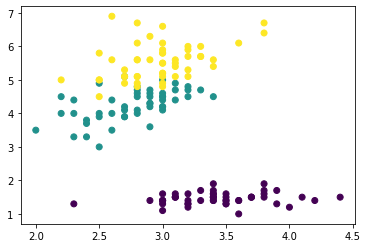

In [4]:
# For the moment we only take a couple of features from the IRIS dataset, for convenience of visualization 

iris = load_iris()
X = iris.data[:, 1:3]  
Y = iris.target

print(X.shape)
print(Y.shape)
plt.scatter(X[:,0],X[:,1], c=Y)

The probability that the unclassified sample x_new belongs to class c will be computed as follows:
<img src="https://github.com/lopeLH/Gaussian-Bayes-classifier/blob/master/probs.PNG?raw=true">

To keep things as simple as possible we use a uniform prior so:

$P(y_{new} = c \mid X,Y) = 1/C $

Finally, we use Gaussian class-conditional distributions (with no naive asumptions):

$P(x_{new} \mid y_{new} = c, X, Y) = \mathcal{N}(\mu_c,\sum_c)$

For a detailed description on how to calculate $\mu_c$ and $\sum_c$ please refer to Rogers et al. (2015)

Rogers, S., & Girolami, M. (2015). A first course in machine learning. CRC Press.

In [5]:
#Actual algorithm implementation.

class BayesClassifier:
    
    mu = None
    cov = None
    n_classes = None
    
    def __init__(self):
        a = None
    
    def pred(self,x):
        prob_vect = np.zeros(self.n_classes)
        
        for i in range(self.n_classes):
            
            
            mnormal = multivariate_normal(mean=bc.mu[i], cov=bc.cov[i])
            
            # We use uniform priors
            prior = 1./self.n_classes
            
            prob_vect[i] = prior*mnormal.pdf(x)
            sumatory = 0.
            for j in range(self.n_classes):
                mnormal = multivariate_normal(mean=bc.mu[j], cov=bc.cov[j])
                sumatory += prior*mnormal.pdf(x)
            prob_vect[i] = prob_vect[i]/sumatory
        return prob_vect
        
    def fit(self, X,y):
        self.mu = []
        self.cov = []
        
        self.n_classes = np.max(y)+1
        
        for i in range(self.n_classes):
            Xc = X[y==i]
            
            mu_c = np.mean(Xc, axis=0)
            self.mu.append(mu_c)
            
            cov_c = np.zeros((X.shape[1], X.shape[1]))
            for j in range( Xc.shape[0]):
                a = Xc[j].reshape((X.shape[1],1))
                b = Xc[j].reshape((1,X.shape[1]))
                cov_ci = np.multiply(a, b)
                cov_c = cov_c+cov_ci
            cov_c = cov_c/float(X.shape[0])
            self.cov.append(cov_c)
        self.mu = np.asarray(self.mu)
        self.cov = np.asarray(self.cov)

In [6]:
# Fit the classifier on the two-feature dataset

bc = BayesClassifier()

bc.fit(X,Y)

In [7]:
#Some spaghetti code to visualize the class-conditional distributions, only works with n_classes = 3!


cols = ["blue", "green", "red"]

for c in range(bc.n_classes):
    var = multivariate_normal(mean=bc.mu[c], cov=bc.cov[c])

    x = np.arange(1.5,5,(5-1.5)/70)
    y = -1*np.arange(-8,0,8./70)
    Xm,Ym = np.meshgrid(x, y)
    Z = Xm

    for i in range(y.shape[0]) :
        for j in range(x.shape[0]):
            plt.scatter([Xm[i][j]],[Ym[i][j]], alpha=1.1*var.pdf([Xm[i][j],Ym[i][j]]),
                        c=cols[c], linewidths=0, s=10, marker="o")
            
    
plt.scatter(X[:,0],X[:,1], c=Y)       
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f97e863a3a0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f97ba724820> (for post_execute):


KeyboardInterrupt: 

In [8]:
#Compare our implementation to the Gaussian NB classifier in sklearn (I win, yeah!)

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
Y = iris.target
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)

bc = BayesClassifier()
bc.fit(X_train, y_train)

nb = GaussianNB()
nb.fit(X_train, y_train)

hit = 0.

for i in range(X_test.shape[0]):
    ypred = bc.pred(X_test[i])
    if np.argmax(ypred) == y_test[i]:
        hit += 1

print("Not so naive Gaussian bayes score: "+str(hit/X_test.shape[0]))
print("Naive Gausian bayes score (sklearn): " +str(nb.score(X_test, y_test)))



Not so naive Gaussian bayes score: 0.9666666666666667
Naive Gausian bayes score (sklearn): 0.9333333333333333
